# Lines detection

1. The line is represented in polar system of coordinate by equation: x*cos(theta) - y*sin(theta) = d,
    where d - distance from the start of coordinate to the line (perpendicular)
            theta - angle of this perpendicular
2. Initialize accumulator array H[d, theta] = 0 - cells correspond to quantized values of 'd' and 'theta'
3. For each edge point in the image:
    for theta=0 to 180 # any other quantization of theta is possible
        d = xcos(theta)+ysin(theta)  # d could be negative, leave cells in H for negative values as well
        H[d, theta] += 1
4. Find the values of (d, theta) where H[d, theta] is maximum. This describes corresponding lines (infinite line).
5. (Optional) Using some rules, you could construct line-segments from points contributed to infinite line (from max to min, using max distance thresholds, etc.)

Noise: increases peaks dispersion around ground truth peak point. The damage could be reduced by smooth accumulator image or increasing cell sizes of accumulator.
Some random lines could be found accidentally if there is no real line or parameters hasn't been tuned right.

Extension:
1. Replace cycle over theta ('for theta=0 to 180') by theta=gradient(x,y) (range of angles around gradient could be considered as well) - reduces computational expenses
2. Give more votes for stronger edges
3. Find lines using lage bins and search regions of interest with smaller bins - increases computational efficiency.
4. The algorithm could be generalized for any type of parametrized figures

In [31]:
import math

import cv2 as cv
import numpy as np
from opencv_.utils import show

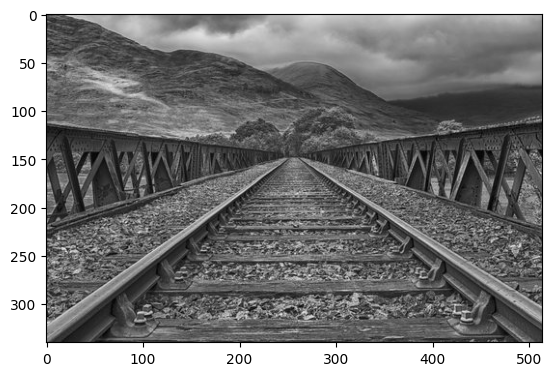

In [22]:
img_original = cv.imread('./3_images/lines_railway.jpg', cv.IMREAD_GRAYSCALE)
show(img_original)

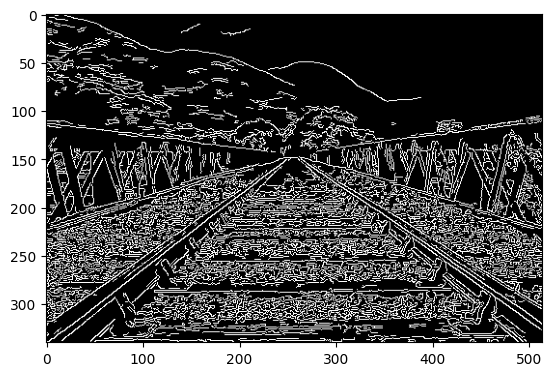

In [39]:
img_edges = cv.Canny(img_original, 120, 254, True)
show(img_edges)

## The Standard Hough Transform

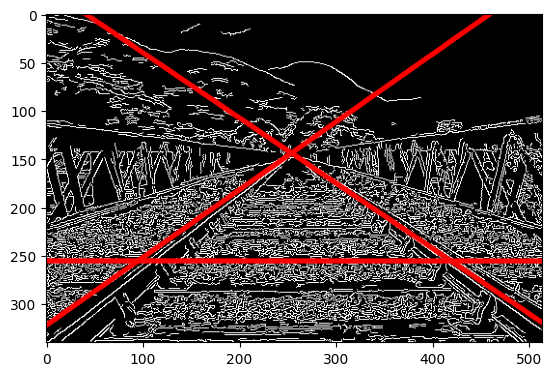

In [52]:
lines = cv.HoughLines(img_edges, 1, np.pi / 180, 220)
img_result = cv.cvtColor(img_edges, cv.COLOR_GRAY2BGR)

for i in range(0, len(lines)):
    rho = lines[i][0][0]
    theta = lines[i][0][1]
    a = math.cos(theta)
    b = math.sin(theta)
    x0 = a * rho
    y0 = b * rho
    pt1 = (int(x0 + 1000*(-b)), int(y0 + 1000*(a)))
    pt2 = (int(x0 - 1000*(-b)), int(y0 - 1000*(a)))
    cv.line(img_result, pt1, pt2, (0,0,255), 3, cv.LINE_AA)

show(img_result)

## The Probabilistic Hough Line Transform

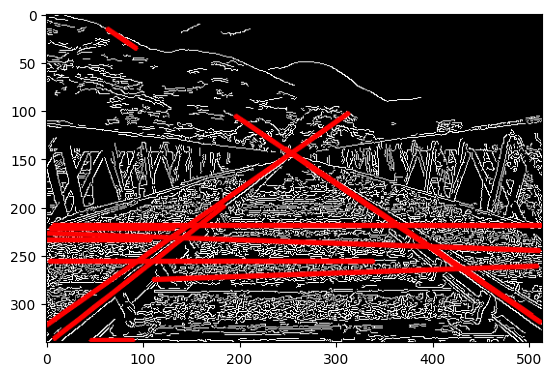

In [65]:
img_result_p = cv.cvtColor(img_edges, cv.COLOR_GRAY2BGR)
linesP = cv.HoughLinesP(img_edges, 1, np.pi / 180, 200, None, 10, 20)

if linesP is not None:
    for i in range(0, len(linesP)):
        l = linesP[i][0]
        cv.line(img_result_p, (l[0], l[1]), (l[2], l[3]), (0,0,255), 3, cv.LINE_AA)

show(img_result_p)

# Circles detection
1. Circle equation: $(x-a)^{2} + (y-b)^{2} = r^{2}$
2. Initialize accumulator array H[a, b, r] = 0 - cells correspond to quantized values of ‘a’, ‘b’ and 'r'
3. for each edge point in the image:
    for each possible radius value r:
        for each possible gradient direction theta (or use single estimated gradient):
            a = x - r * cos(theta)
            b = y + r * sin(theta)
            H[a, b, r] += 1
4. Find the values of (a, b, r) where H[a, b, r] is maximum. This describes circles

Practical tips:
1. Minimize irrelevant tokens first (take edge points with significant gradient magnitude)
2. Choose a good grid / discretization
3. Vote for neighboring bins (like smoothing in accumulator array)
4. Utilize direction of edge to reduce free parameters by 1

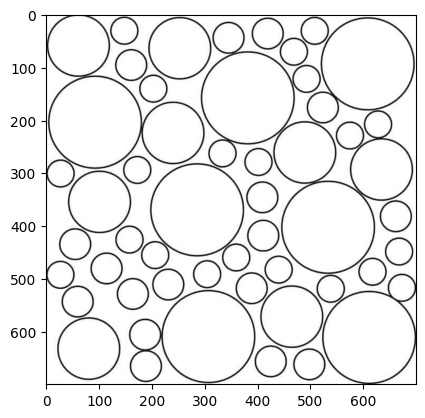

In [68]:
img_original = cv.imread('./3_images/circles.jpg', cv.IMREAD_GRAYSCALE)
show(img_original)

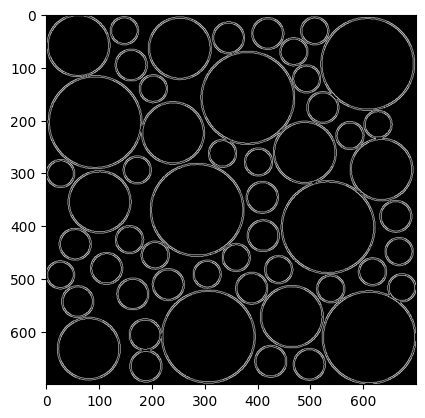

In [84]:
img_edges = cv.Canny(img_original, 254, 254, True)
show(img_edges)

In [127]:
circles = cv.HoughCircles(img_original, cv.HOUGH_GRADIENT, 2, 50,
                          param1=254, param2=254, minRadius=0, maxRadius=0)
circles = np.uint16(np.around(circles))

In [128]:
img_result = cv.cvtColor(img_original, cv.COLOR_GRAY2BGR)

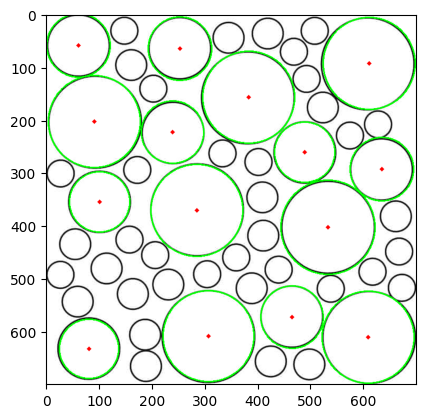

In [129]:
for i in circles[0,:]:
    # draw the outer circle
    cv.circle(img_result,(i[0],i[1]),i[2],(0,255,0),2)
    # draw the center of the circle
    cv.circle(img_result,(i[0],i[1]),2,(0,0,255),3)

show(img_result)

# Generalized Hough Transform
1. In target template define reference point C
2. Initialize accumulator array H[x, y] = 0 - cells correspond to quantized values of ‘x' and 'y' coordinates of templates center
3. For each edge point in template $p_i$ compute gradient theta and displacement $r = C - p_i$. Store these variables in table indexed by theta.
4. for each edge point in the image:
    compute gradient direction theta
    retrieve all displacement vectors r corresponding to theta
    vote for all retrieved vectors r
5. Find the values of (x, y) where H[x, y] is maximum.

Notes:
For arbitrary rotation: add additional dimension to the H matrix and consider different rotations using it (actually solve the task for each of possible rotations)
For arbitrary scale: the same approach as with arbitrary scale

More modern application: use visual code words instead of boundary points